In [3]:
! pip install kaggle    # Install the Kaggle library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle        # Make a directory named “.kaggle”

In [5]:
! cp kaggle.json ~/.kaggle/         # Copy the “kaggle.json” into this new directory

In [6]:
! chmod 600 ~/.kaggle/kaggle.json        # Allocate the required permission for this file.

In [7]:
! kaggle datasets download kazanova/sentiment140

 94% 76.0M/80.9M [00:00<00:00, 150MB/s]
100% 80.9M/80.9M [00:00<00:00, 130MB/s]


In [8]:
! unzip sentiment140

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = columns , encoding='latin-1')

In [48]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [49]:
print('number of rows:', df.shape[0], '\nnumber of columns:', df.shape[1])

number of rows: 1600000 
number of columns: 6


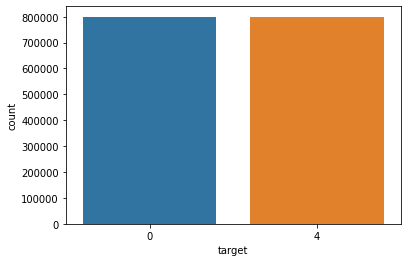

In [50]:
sns.countplot(x=df['target']); # shows a count plot refering to the number of 0 and 4 in the column

In [51]:
df['target']=df['target'].replace(4,1) 

In [52]:
def preprocessing(sentence):
    """
    lowecase, tokenize, drop stop words
    """

    # convert to lower case and remove remaining tokens that are not alphabetic and number
    sentence = sentence.lower()
    sentence = re.sub(r"<br />", "", sentence)
    sentence = re.sub(r"[^a-z0-9 ]", "", sentence)  ## Just keep a-z and 0-9
    sentence = re.sub(r"\s+", " ", sentence)     ## Eliminate duplicate whitespaces using wildcards
    tokenized = nltk.tokenize.word_tokenize(sentence)
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokenized = [word for word in tokenized if word not in stop_words]

    # join words to a sentence
    to_sentence = ' '.join(tokenized)

    return to_sentence



In [53]:
print('Before: {}'. format(list(df['text'][:2])))
print('---')
print('After: {}'. format(list(df['text'][:2].apply(preprocessing))))

Before: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
---
After: ['switchfoot httptwitpiccom2y1zl awww thats bummer shoulda got david carr third day', 'upset cant update facebook texting might cry result school today also blah']


In [54]:
df['text'] = df['text'].apply(preprocessing)

In [56]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save 50...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass behaving im mad cant see


In [57]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],
                                                    test_size=0.2, random_state=42)

In [58]:
num_words =3000
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1    #  tokenizer.word_index return {'the': 1,'a': 2,'and': 3,'of': 4,'to': 5,....}

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

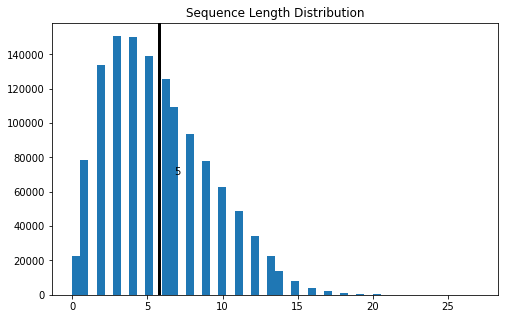

In [59]:
length_list = list(map(len, X_train_tk))

plt.figure(figsize=(8, 5))
plt.hist(length_list, bins=50)
plt.axvline(np.mean(length_list), linewidth=3, c='k')
plt.text(x=np.mean(length_list)+1, y=70000, s=int(np.mean(length_list)))
plt.title("Sequence Length Distribution")
plt.show()

In [61]:
maxlen = 10

X_train_pad = pad_sequences(X_train_tk, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_tk, maxlen=maxlen)

In [62]:
X_train_pad.shape, X_test_pad.shape

((1280000, 10), (320000, 10))

In [63]:
def model():
    inputs_ = tf.keras.Input(shape=maxlen)
    embedding = tf.keras.layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen)(inputs_)
    average_pool = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    outputs_ = tf.keras.layers.Dense(1, activation='sigmoid')(average_pool)
    model = tf.keras.Model(inputs=[inputs_], outputs=[outputs_])
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics='accuracy')
    return model

In [64]:
tf.keras.backend.clear_session()
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 128)           384000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 384,129
Trainable params: 384,129
Non-trainable params: 0
_________________________________________________________________


In [65]:
# ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights
# (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training
# from the state saved

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('review_classify.hdf5',
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   save_best_only=True,
                                                   save_weights_only=True)

# If we want to load model later we should set save_weights_only=False in 
# tf.keras.callbacks.ModelCheckpoint and use below command.
# new_model = tf.keras.models.load_model("/kaggle/working/review_classify.hdf5")


# EarlyStopping: Stop training when a monitored metric has stopped improving.
# patience: Number of epochs with no improvement after which training will be stopped.
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    mode='max',
                                                    patience=5)             


model.fit(X_train_pad, y_train,
         batch_size=128,
         epochs=10,
         validation_split=0.2,
         callbacks=[checkpoint_cb, earlystopping_cb])

Epoch 1/10
8000/8000 [==============================] - 72s 9ms/step - loss: 0.5079 - accuracy: 0.7583 - val_loss: 0.5015 - val_accuracy: 0.7636
Epoch 2/10
8000/8000 [==============================] - 74s 9ms/step - loss: 0.4998 - accuracy: 0.7635 - val_loss: 0.5005 - val_accuracy: 0.7651
Epoch 3/10
8000/8000 [==============================] - 71s 9ms/step - loss: 0.4989 - accuracy: 0.7648 - val_loss: 0.4991 - val_accuracy: 0.7653
Epoch 4/10
8000/8000 [==============================] - 69s 9ms/step - loss: 0.4983 - accuracy: 0.7650 - val_loss: 0.4986 - val_accuracy: 0.7659
Epoch 5/10
8000/8000 [==============================] - 69s 9ms/step - loss: 0.4979 - accuracy: 0.7654 - val_loss: 0.4982 - val_accuracy: 0.7658
Epoch 6/10
8000/8000 [==============================] - 67s 8ms/step - loss: 0.4976 - accuracy: 0.7655 - val_loss: 0.4986 - val_accuracy: 0.7665
Epoch 7/10
8000/8000 [==============================] - 67s 8ms/step - loss: 0.4974 - accuracy: 0.7656 - val_loss: 0.4983 - val_ac